In [1]:
import os
import random
import shutil
import pathlib
import numpy as np

def split_dir_to_train_test_val(directory="Dataset_protoV3/", train_size=0.7, test_size=0.2, val_size=0.1):
    rng = random.Random(42)

    for root, folders, files in os.walk(directory):
        for folder in folders:
            # Buat daftar file dalam folder
            list_of_files = []
            folder_path = os.path.join(root, folder)
            for file_name in os.listdir(folder_path):
                list_of_files.append(file_name)

            # Acak daftar file
            rng.shuffle(list_of_files)

            # Buat daftar file untuk setiap subset
            train_files = list_of_files[:int(len(list_of_files) * train_size)]
            test_files = list_of_files[int(len(list_of_files) * train_size):int(len(list_of_files) * (train_size + test_size))]
            val_files = list_of_files[int(len(list_of_files) * (train_size + test_size)):]

            # Salin file ke folder train
            for one_file in train_files:
                dest_dir = os.path.join("files/train", folder)
                os.makedirs(dest_dir, exist_ok=True)
                shutil.copy2(src=os.path.join(folder_path, one_file), dst=os.path.join(dest_dir, one_file))
            print(f"Folder {folder}. Train data copied. {len(train_files)} files")

            # Salin file ke folder test
            for one_file in test_files:
                dest_dir = os.path.join("files/test", folder)
                os.makedirs(dest_dir, exist_ok=True)
                shutil.copy2(src=os.path.join(folder_path, one_file), dst=os.path.join(dest_dir, one_file))
            print(f"Folder {folder}. Test data copied. {len(test_files)} files")

            # Salin file ke folder validation
            for one_file in val_files:
                dest_dir = os.path.join("files/validation", folder)
                os.makedirs(dest_dir, exist_ok=True)
                shutil.copy2(src=os.path.join(folder_path, one_file), dst=os.path.join(dest_dir, one_file))
            print(f"Folder {folder}. Validation data copied. {len(val_files)} files")

def get_class_names_from_folder(directory):
    """
    Dapatkan nama kelas dari folder
    """
    data_dir = pathlib.Path(directory)
    class_names = np.array(sorted([item.name for item in data_dir.glob("*") if item.is_dir()])) # Buat daftar nama kelas
    return class_names

# Contoh penggunaan fungsi
split_dir_to_train_test_val(directory="Dataset_protoV3/", train_size=0.7, test_size=0.2, val_size=0.1)
class_names = get_class_names_from_folder("files/train")
print(f"Class names: {class_names}")


Folder A_LeafBlight_Proto. Train data copied. 147 files
Folder A_LeafBlight_Proto. Test data copied. 41 files
Folder A_LeafBlight_Proto. Validation data copied. 22 files
Folder A_LeafRust_Proto. Train data copied. 147 files
Folder A_LeafRust_Proto. Test data copied. 41 files
Folder A_LeafRust_Proto. Validation data copied. 22 files
Folder A_LeafSpot_Proto. Train data copied. 147 files
Folder A_LeafSpot_Proto. Test data copied. 41 files
Folder A_LeafSpot_Proto. Validation data copied. 22 files
Class names: ['A_LeafBlight_Proto' 'A_LeafRust_Proto' 'A_LeafSpot_Proto']


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Rescaling, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Note: Data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "files/train"
test_dir = "files/test"
val_dir = "files/validation"

IMG_SIZE = (240, 240)
BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(train_dir, shuffle=True, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
validation_dataset = image_dataset_from_directory(val_dir, shuffle=True, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
test_dataset = image_dataset_from_directory(test_dir, shuffle=True, image_size=IMG_SIZE, batch_size=BATCH_SIZE)

normalization_layer = Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Using pretrained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# Freezing the base model
for layer in base_model.layers:
    layer.trainable = False

# Adding custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compiling model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.90 and logs.get('val_accuracy') >= 0.90:
            print(f"\nStopping training as training accuracy {logs.get('accuracy'):.4f} >= 0.90 and validation accuracy {logs.get('val_accuracy'):.4f} >= 0.90\n")
            self.model.stop_training = True

# Callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)
early_stopping = CustomEarlyStopping()

callbacks = [checkpoint, reduce_lr, early_stopping]

# Training model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=35,
    callbacks=callbacks
)

# Evaluating model
best_model = tf.keras.models.load_model("best_model.keras")
loss, accuracy = best_model.evaluate(test_dataset)
print(f"Best model validation accuracy: {accuracy}")



Found 14922 files belonging to 3 classes.
Found 2165 files belonging to 3 classes.
Found 4303 files belonging to 3 classes.


Epoch 1/35


467/467 [==============================] - ETA: 0s - loss: 0.7173 - accuracy: 0.6785
Epoch 1: val_accuracy improved from -inf to 0.77598, saving model to best_model.keras
467/467 [==============================] - 1153s 2s/step - loss: 0.7173 - accuracy: 0.6785 - val_loss: 0.5377 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 2/35
467/467 [==============================] - ETA: 0s - loss: 0.5354 - accuracy: 0.7702
Epoch 2: val_accuracy improved from 0.77598 to 0.81524, saving model to best_model.keras
467/467 [==============================] - 1141s 2s/step - loss: 0.5354 - accuracy: 0.7702 - val_loss: 0.4551 - val_accuracy: 0.8152 - lr: 0.0010
Epoch 3/35
467/467 [==============================] - ETA: 0s - loss: 0.4730 - accuracy: 0.7995
Epoch 3: val_accuracy improved from 0.81524 to 0.82725, saving model to best_model.keras
467/467 [==================

In [3]:
model.evaluate(test_dataset)

135/135 [==============================] - 313s 2s/step - loss: 0.2782 - accuracy: 0.8850


[0.2782253324985504, 0.8849639892578125]

<Axes: >

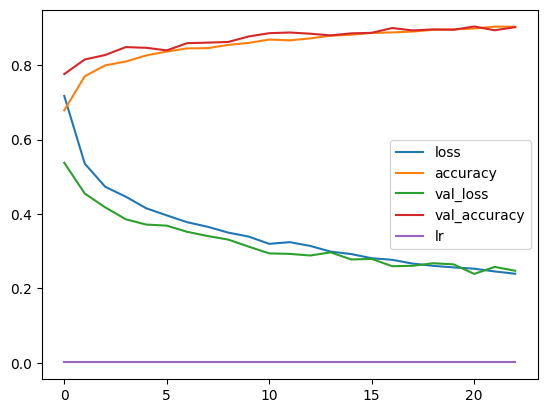

In [4]:
import pandas as pd

pd.DataFrame(history.history).plot()

In [6]:
def load_and_preprocess_image(filename, size):
    # Load image
    img = tf.io.read_file(filename)
    # Decode image
    img = tf.image.decode_image(img, channels=3)  # Ensure RGB channels
    # Resize image
    img = tf.image.resize(img, [size, size])
    # Rescale the tensor
    img = img / 255.0
    return img

# Folder containing the images to predict
prediction_folder = "TESTING DATA BARU/SPOT_BARU"

# Get all files in the prediction folder
all_files = os.listdir(prediction_folder)

# Filter out only image files
image_files = [f for f in all_files if f.endswith((".jpg", ".png", ".jpeg"))]

# Print the total number of image files found
print(f"Total number of image files: {len(image_files)}")

# Loop through each image file in the folder
for filename in image_files:
    file_path = os.path.join(prediction_folder, filename)
    print(f"Predicting class for {file_path}")

    # Load and preprocess the image
    image = load_and_preprocess_image(file_path, 240)  # Adjust size if needed

    # Expand dimensions to create a batch (required by the model)
    image = tf.expand_dims(image, axis=0)

    # Make predictions
    predictions = model.predict(image)

    # Get the index of the predicted class
    predicted_class_index = predictions[0].argmax()

    # Get the predicted class name using the index
    predicted_class_name = class_names[predicted_class_index]
    # Get the confidence score
    confidence_score = float(np.max(predictions[0]))
    
    # Print the predicted class name and confidence score
    print("Predicted class:", predicted_class_name)
    print("Confidence score:", confidence_score)

Total number of image files: 410
Predicting class for TESTING DATA BARU/SPOT_BARU\001005.jpg
1/1 [==============================] - 0s 94ms/step
Predicted class: A_LeafSpot_Proto
Confidence score: 0.9347127079963684
Predicting class for TESTING DATA BARU/SPOT_BARU\001011.jpg
1/1 [==============================] - 0s 98ms/step
Predicted class: A_LeafSpot_Proto
Confidence score: 0.6506020426750183
Predicting class for TESTING DATA BARU/SPOT_BARU\001015.jpg
1/1 [==============================] - 0s 100ms/step
Predicted class: A_LeafSpot_Proto
Confidence score: 0.9914576411247253
Predicting class for TESTING DATA BARU/SPOT_BARU\001019.jpg
1/1 [==============================] - 0s 105ms/step
Predicted class: A_LeafRust_Proto
Confidence score: 0.8674370646476746
Predicting class for TESTING DATA BARU/SPOT_BARU\001021.jpg
1/1 [==============================] - 0s 112ms/step
Predicted class: A_LeafRust_Proto
Confidence score: 0.600441575050354
Predicting class for TESTING DATA BARU/SPOT_BARU\0

In [10]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

# Folder containing the images to predict
prediction_folder = "TESTING DATA BARU/SPOT_BARU"

# Get all files in the prediction folder
all_files = os.listdir(prediction_folder)

# Filter out only image files
image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Print the total number of image files found
print(f"Total number of image files: {len(image_files)}")

# Function to load and preprocess image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Loop through each image file in the folder
for filename in image_files:
    file_path = os.path.join(prediction_folder, filename)
    print(f"Predicting class for {file_path}")

    try:
        # Load and preprocess the image
        img_array = load_and_preprocess_image(file_path, (240, 240))  # Adjust size if needed
        
        # Make predictions
        predictions = model.predict(img_array)

        # Assuming your model outputs class probabilities and you want to get the predicted class index
        predicted_class_index = np.argmax(predictions, axis=-1)[0]
        
        # Get the predicted class name (you need to define your class_names list or dictionary)
        predicted_class_name = class_names[predicted_class_index]

        # Print the predicted class name
        print("Predicted class:", predicted_class_name)
    
    except Exception as e:
        print(f"Error predicting for {file_path}: {e}")



Total number of image files: 611
Predicting class for TESTING DATA BARU/SPOT_BARU\001005.jpg
1/1 [==============================] - 0s 107ms/step
Predicted class: A_LeafSpot_Proto
Predicting class for TESTING DATA BARU/SPOT_BARU\001011.jpg
1/1 [==============================] - 0s 92ms/step
Predicted class: A_LeafRust_Proto
Predicting class for TESTING DATA BARU/SPOT_BARU\001015.jpg
1/1 [==============================] - 0s 92ms/step
Predicted class: A_LeafSpot_Proto
Predicting class for TESTING DATA BARU/SPOT_BARU\001019.jpg
1/1 [==============================] - 0s 94ms/step
Predicted class: A_LeafSpot_Proto
Predicting class for TESTING DATA BARU/SPOT_BARU\001021.jpg
1/1 [==============================] - 0s 96ms/step
Predicted class: A_LeafSpot_Proto
Predicting class for TESTING DATA BARU/SPOT_BARU\001023.jpg
1/1 [==============================] - 0s 92ms/step
Predicted class: A_LeafSpot_Proto
Predicting class for TESTING DATA BARU/SPOT_BARU\001025.jpg
1/1 [=========================

# CONVERT CORNER

In [7]:
# Menyimpan model sebagai SavedModel
model.save('saved_model/my_modelV3_1')

INFO:tensorflow:Assets written to: saved_model/my_modelV3_1\assets


INFO:tensorflow:Assets written to: saved_model/my_modelV3_1\assets


In [9]:
# Simpan model dalam format HDF5
model.save('my_modelV3_1.h5')


In [37]:
!tensorflowjs_converter --input_format keras best_model.h5 tfjs_model

^C


In [ ]:
import tensorflow as tf

# Assuming `model` is your trained model
tf.saved_model.save(model, "./FolderUntukTFJS2/saved_model")


In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model ./FolderUntukTFJS2/saved_model ./FolderUntukTFJS2/tfjs_model

In [ ]:
import sys
print(sys.version)

In [ ]:
import pathlib

# Jadikan SavedModel
export_dir = 'FolderUntukTFJS'
tf.saved_model.save(model, export_dir)


In [ ]:
# Convert The Model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
# Save The Model
tflite_model_file = pathlib.Path('CheckpointModel/ProtoModel.tflite')
tflite_model_file.write_bytes(tflite_model)                      